Computing trend/seasonal via STL jump ...

=== Horizon: label_1h ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's rmse: 577.278	valid_0's l2: 333250
 Best iteration (n_estimators): 82
 Saved LGBM_FINAL_label_1h.pkl
 Test label_1h: RMSE=391.1198, MAPE=0.32%


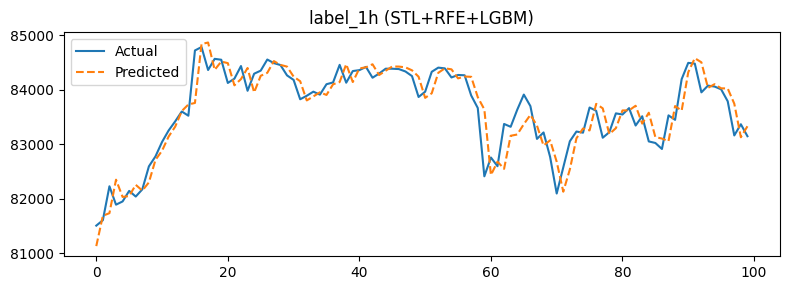


=== Horizon: label_2h ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's rmse: 787.182	valid_0's l2: 619655
 Best iteration (n_estimators): 80
 Saved LGBM_FINAL_label_2h.pkl
 Test label_2h: RMSE=506.1710, MAPE=0.42%


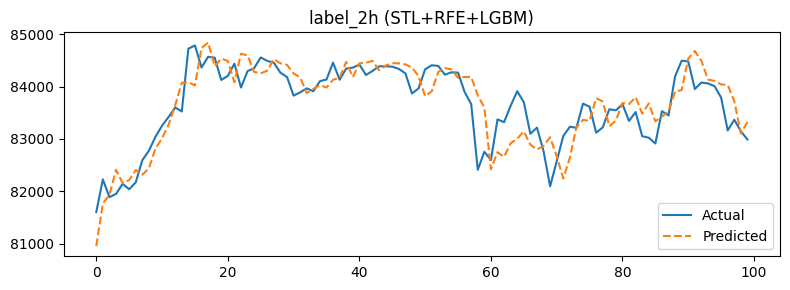


=== Horizon: label_3h ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's rmse: 946.142	valid_0's l2: 895184
 Best iteration (n_estimators): 134
 Saved LGBM_FINAL_label_3h.pkl
 Test label_3h: RMSE=610.1976, MAPE=0.50%


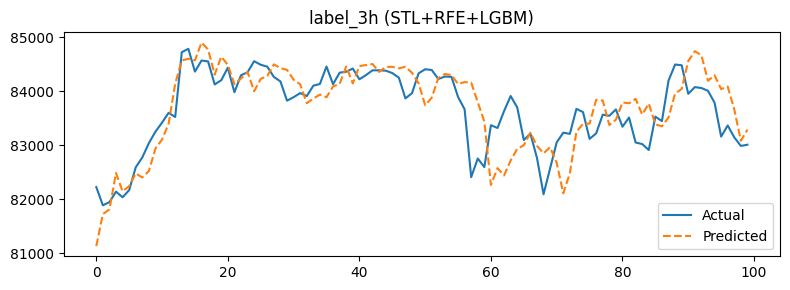


=== Horizon: label_6h ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 1240.93	valid_0's l2: 1.53992e+06
 Best iteration (n_estimators): 138
 Saved LGBM_FINAL_label_6h.pkl
 Test label_6h: RMSE=808.0374, MAPE=0.67%


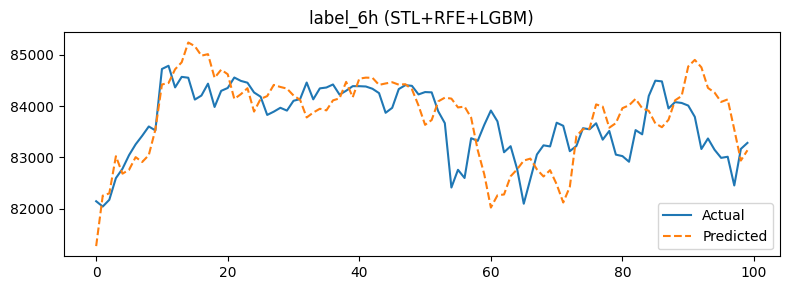


=== Horizon: label_12h ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[306]	valid_0's rmse: 1596.53	valid_0's l2: 2.54892e+06
 Best iteration (n_estimators): 306
 Saved LGBM_FINAL_label_12h.pkl
 Test label_12h: RMSE=1022.0004, MAPE=0.88%


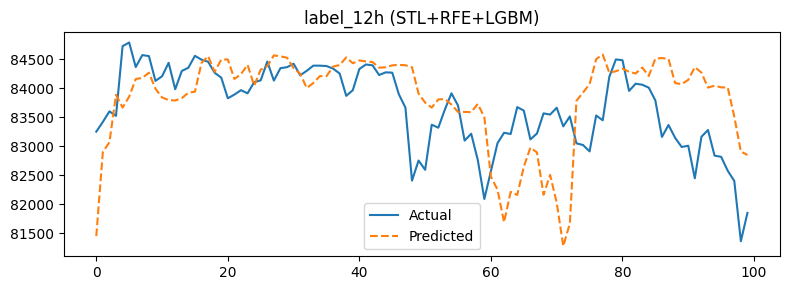


=== Horizon: label_1d ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[234]	valid_0's rmse: 2217.14	valid_0's l2: 4.91573e+06
 Best iteration (n_estimators): 234
 Saved LGBM_FINAL_label_1d.pkl
 Test label_1d: RMSE=1555.9612, MAPE=1.27%


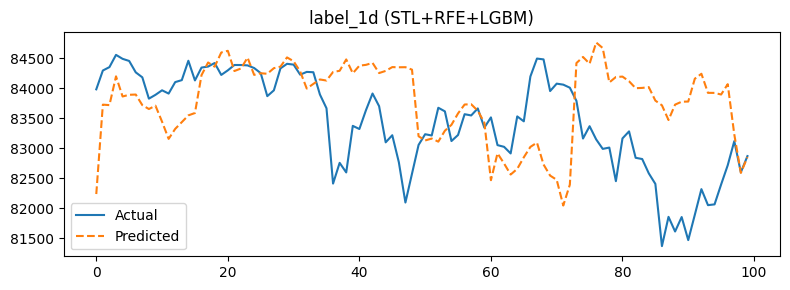


=== Horizon: label_3d ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 3941.1	valid_0's l2: 1.55323e+07
 Best iteration (n_estimators): 1
 Saved LGBM_FINAL_label_3d.pkl
 Test label_3d: RMSE=3450.5715, MAPE=2.97%


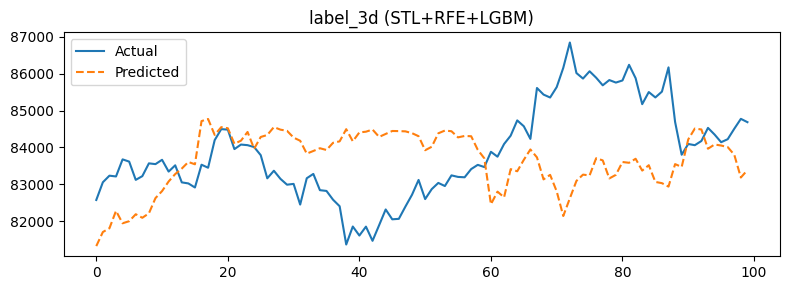


=== Horizon: label_7d ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 5361.78	valid_0's l2: 2.87487e+07
 Best iteration (n_estimators): 3
 Saved LGBM_FINAL_label_7d.pkl
 Test label_7d: RMSE=4779.5715, MAPE=4.14%


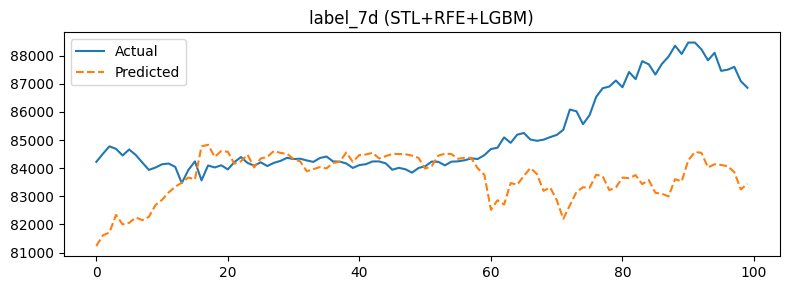


=== Horizon: label_15d ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 7145.07	valid_0's l2: 5.1052e+07
 Best iteration (n_estimators): 1
 Saved LGBM_FINAL_label_15d.pkl
 Test label_15d: RMSE=8182.1522, MAPE=7.28%


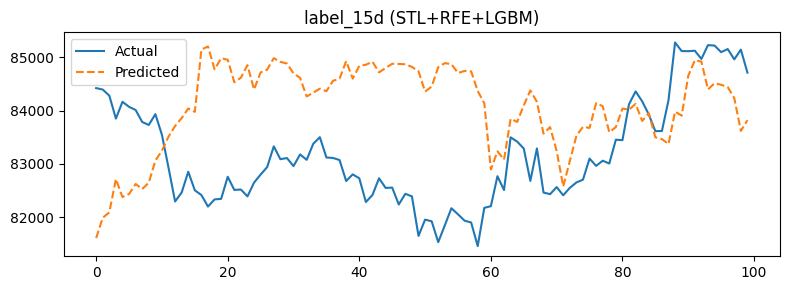


=== Horizon: label_30d ===
 Selected 5 features
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 9456.59	valid_0's l2: 8.94271e+07
 Best iteration (n_estimators): 7
 Saved LGBM_FINAL_label_30d.pkl
 Test label_30d: RMSE=14458.3882, MAPE=12.47%


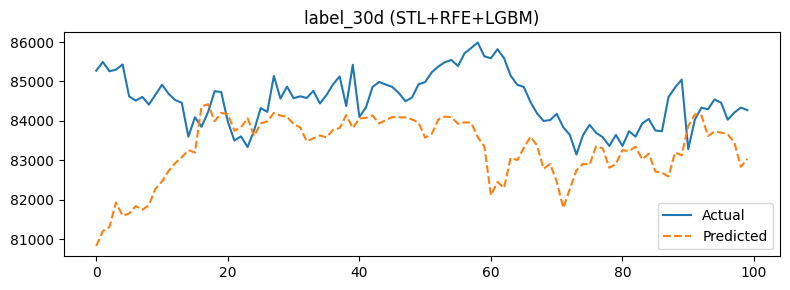

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor, early_stopping
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib

# Paths
TRAIN_CSV = '/kaggle/input/data-btc/fix/fix/train.csv'
VAL_CSV   = '/kaggle/input/data-btc/fix/fix/val.csv'
TEST_CSV  = '/kaggle/input/data-btc/fix/fix/test.csv'

# 1) Load train, val, test
df_tr = pd.read_csv(TRAIN_CSV, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va = pd.read_csv(VAL_CSV,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te = pd.read_csv(TEST_CSV,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) Define horizons & features
HORIZONS = ['1h','2h','3h','6h','12h','1d','3d','7d','15d','30d']
LABELS   = [f'label_{h}' for h in HORIZONS]
FEATURES = [c for c in df_tr.columns if not c.startswith('label_')]

# 3) Compute STL trend+season for train+val+test
PERIOD     = 24
JUMP       = 24
close_all  = pd.concat([df_tr['close'], df_va['close'], df_te['close']], ignore_index=True)
trend_all  = np.zeros_like(close_all)
season_all = np.zeros_like(close_all)
window_len = PERIOD * 2 + 1

print("Computing trend/seasonal via STL jump ...")
for t in range(len(close_all)):
    start = max(0, t - window_len + 1)
    sub   = close_all.iloc[start:t+1]
    dec   = STL(sub, period=PERIOD, trend_jump=JUMP,
                low_pass_jump=JUMP, robust=True).fit()
    trend_all[t]  = dec.trend.iloc[-1]
    season_all[t] = dec.seasonal.iloc[-1]

# split back
n_tr = len(df_tr)
n_va = len(df_va)
trend_tr, trend_va, trend_te     = trend_all[:n_tr], trend_all[n_tr:n_tr+n_va], trend_all[n_tr+n_va:]
season_tr, season_va, season_te = season_all[:n_tr], season_all[n_tr:n_tr+n_va], season_all[n_tr+n_va:]

results = {}

for label in LABELS:
    print(f"\n=== Horizon: {label} ===")
    # 4) residuals on train & val
    y_tr_resid = df_tr[label].values - (trend_tr + season_tr)
    y_va_resid = df_va[label].values - (trend_va + season_va)

    # 5) RFE feature selection on train
    selector = RFE(
        estimator=LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
        n_features_to_select=min(5, len(FEATURES)),
        step=0.1, verbose=0
    )
    selector.fit(df_tr[FEATURES], y_tr_resid)
    feats_sel = [f for f, keep in zip(FEATURES, selector.support_) if keep]
    print(f" Selected {len(feats_sel)} features")

    # 6) Tuning via early stopping on val using callback
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(
        df_tr[feats_sel], y_tr_resid,
        eval_set=[(df_va[feats_sel], y_va_resid)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=50)]
    )
    best_it = model.best_iteration_
    if best_it is None or best_it <= 0:
        best_it = 100  # fallback to initial n_estimators if no early stop

    print(f" Best iteration (n_estimators): {best_it}")

    # 7) Retrain final on train+val
    y_comb_resid = np.concatenate([y_tr_resid, y_va_resid], axis=0)
    df_comb      = pd.concat([df_tr, df_va], ignore_index=True)
    final = LGBMRegressor(
        n_estimators=best_it,
        learning_rate=0.05,
        random_state=42
    )
    final.fit(df_comb[feats_sel], y_comb_resid)

    # 8) Save the final model
    joblib.dump(final, f'LGBM_FINAL_{label}.pkl')
    print(f" Saved LGBM_FINAL_{label}.pkl")

    # 9) Predict & reconstruct on test
    y_te_resid = final.predict(df_te[feats_sel])
    y_pred     = trend_te + season_te + y_te_resid
    y_true     = df_te[label].values

    # 10) Evaluate
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f" Test {label}: RMSE={rmse:.4f}, MAPE={mape:.2f}%")

    # Plot
    plt.figure(figsize=(8,3))
    plt.plot(y_true[:100], label='Actual')
    plt.plot(y_pred[:100], '--', label='Predicted')
    plt.title(f'{label} (STL+RFE+LGBM)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    results[label] = (y_true, y_pred)


LGBM FINAL 2

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's rmse: 577.893	valid_0's l2: 333961
label_1h: RMSE=394.6956, MAPE=0.32%


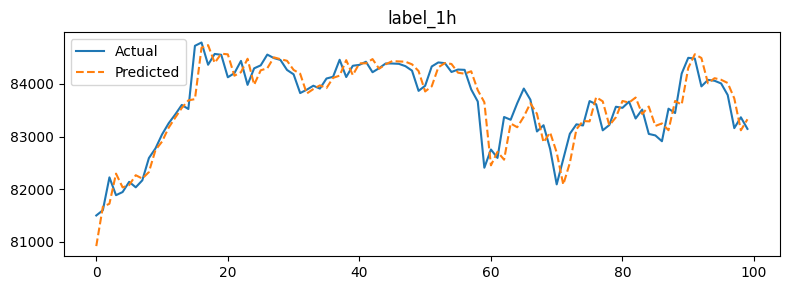

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 782.536	valid_0's l2: 612362
label_2h: RMSE=519.5554, MAPE=0.42%


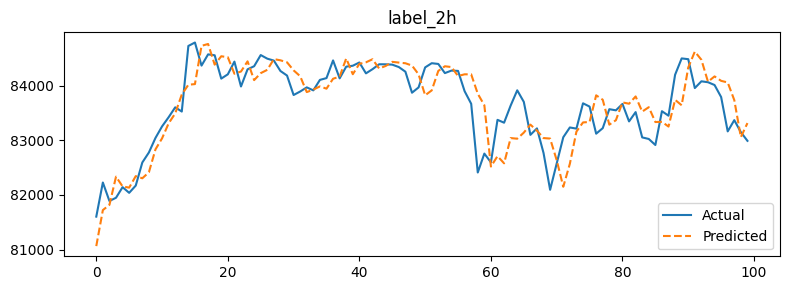

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's rmse: 927.077	valid_0's l2: 859472
label_3h: RMSE=628.0223, MAPE=0.51%


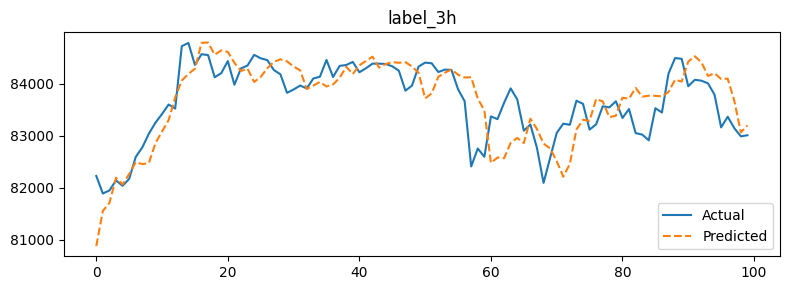

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 1191.01	valid_0's l2: 1.4185e+06
label_6h: RMSE=851.2374, MAPE=0.71%


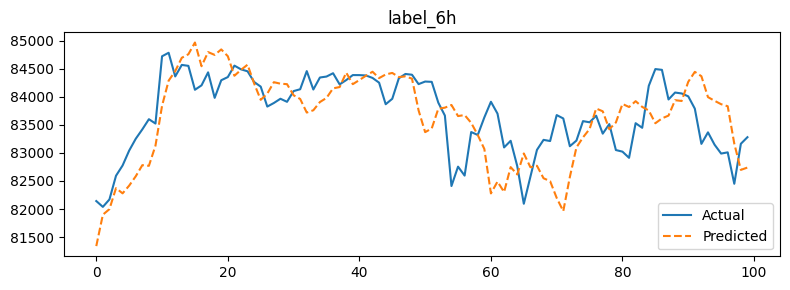

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 1574.07	valid_0's l2: 2.47771e+06
label_12h: RMSE=985.5906, MAPE=0.85%


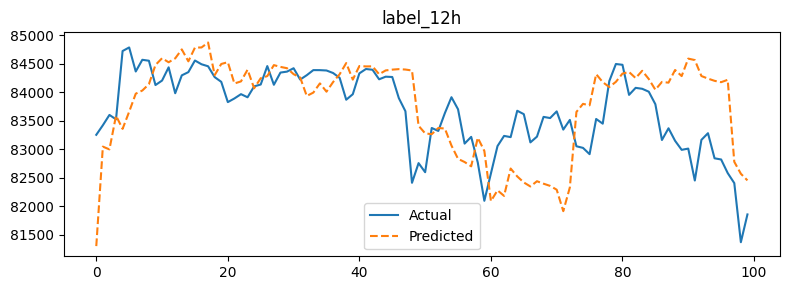

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[392]	valid_0's rmse: 2109.23	valid_0's l2: 4.44884e+06
label_1d: RMSE=1536.5968, MAPE=1.29%


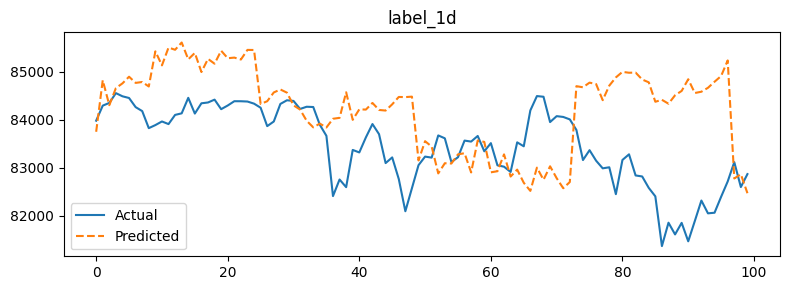

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 3958.53	valid_0's l2: 1.567e+07
label_3d: RMSE=3391.2435, MAPE=2.93%


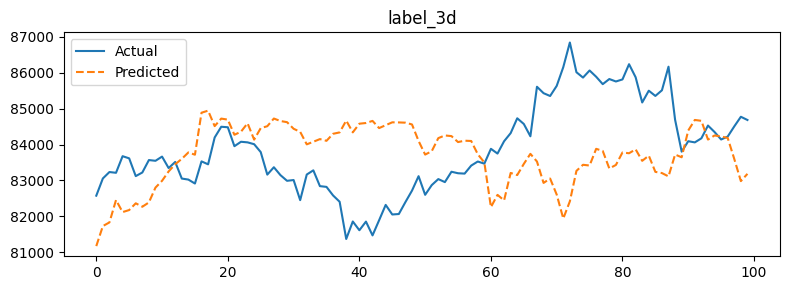

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 5520.44	valid_0's l2: 3.04752e+07
label_7d: RMSE=4963.3343, MAPE=4.31%


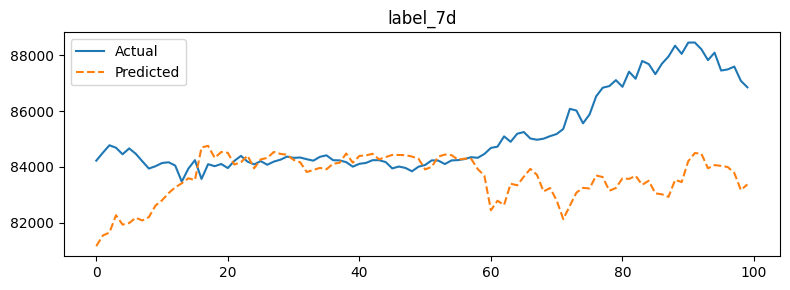

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 7276.86	valid_0's l2: 5.29526e+07
label_15d: RMSE=7937.9896, MAPE=7.07%


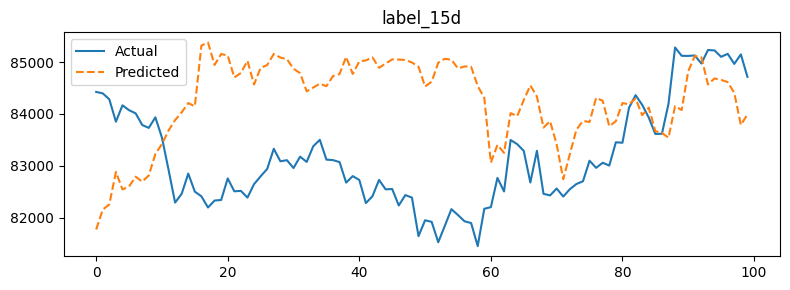

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 10430.1	valid_0's l2: 1.08787e+08
label_30d: RMSE=12925.6730, MAPE=10.86%


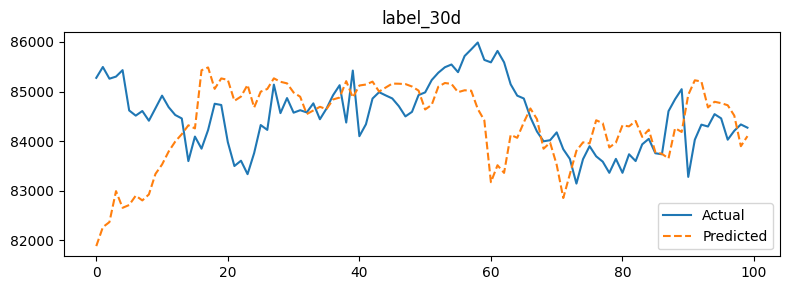

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib

# Paths
TRAIN_CSV = '/kaggle/input/data-btc/fix/fix/train.csv'
VAL_CSV   = '/kaggle/input/data-btc/fix/fix/val.csv'
TEST_CSV  = '/kaggle/input/data-btc/fix/fix/test.csv'

# 1) Load train, val, test
df_tr = pd.read_csv(TRAIN_CSV, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va = pd.read_csv(VAL_CSV,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te = pd.read_csv(TEST_CSV,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) Define horizons & features (exclude labels)
HORIZONS = ['1h','2h','3h','6h','12h','1d','3d','7d','15d','30d']
LABELS   = [f'label_{h}' for h in HORIZONS]
FEATURES = [c for c in df_tr.columns if c not in LABELS]

# 3) Compute STL trend+season for train+val+test
PERIOD     = 24
JUMP       = 24
close_all  = pd.concat([df_tr['close'], df_va['close'], df_te['close']], ignore_index=True)
trend_all  = np.zeros_like(close_all)
season_all = np.zeros_like(close_all)
window_len = PERIOD*2 + 1

for t in range(len(close_all)):
    start = max(0, t - window_len + 1)
    sub   = close_all.iloc[start:t+1]
    dec   = STL(sub, period=PERIOD, trend_jump=JUMP, low_pass_jump=JUMP, robust=True).fit()
    trend_all[t]  = dec.trend.iloc[-1]
    season_all[t] = dec.seasonal.iloc[-1]

n_tr = len(df_tr)
n_va = len(df_va)
trend_tr, trend_va, trend_te     = trend_all[:n_tr], trend_all[n_tr:n_tr+n_va], trend_all[n_tr+n_va:]
season_tr, season_va, season_te = season_all[:n_tr], season_all[n_tr:n_tr+n_va], season_all[n_tr+n_va:]

results = {}

for label in LABELS:
    # residuals
    y_tr = df_tr[label].values - (trend_tr + season_tr)
    y_va = df_va[label].values - (trend_va + season_va)

    # 4) Tuning via early stopping & suppress info
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42,
        verbose=-1               # disable LightGBM info :contentReference[oaicite:0]{index=0}
    )
    model.fit(
        df_tr[FEATURES], y_tr,
        eval_set=[(df_va[FEATURES], y_va)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50),  
            log_evaluation(period=0)            # turn off iteration logs :contentReference[oaicite:1]{index=1}
        ]
    )
    best_it = model.best_iteration_
    best_it = best_it if best_it and best_it > 0 else 100  # fallback

    # 5) Retrain final on train+val
    y_comb = np.concatenate([y_tr, y_va], axis=0)
    df_comb = pd.concat([df_tr, df_va], ignore_index=True)
    final = LGBMRegressor(
        n_estimators=best_it,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    final.fit(df_comb[FEATURES], y_comb)

    # save model
    joblib.dump(final, f'LGBM_FINAL_{label}.pkl')

    # 6) Predict & reconstruct price
    y_te_resid = final.predict(df_te[FEATURES])
    y_pred     = trend_te + season_te + y_te_resid
    y_true     = df_te[label].values

    # 7) Print RMSE & MAPE only
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f'{label}: RMSE={rmse:.4f}, MAPE={mape:.2f}%')

    # 8) Plot
    plt.figure(figsize=(8,3))
    plt.plot(y_true[:100], label='Actual')
    plt.plot(y_pred[:100], '--', label='Predicted')
    plt.title(f'{label}')
    plt.legend()
    plt.tight_layout()
    plt.show()


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 595.695	valid_0's l2: 354852
label_1h: RMSE=412.8771, MAPE=0.32%


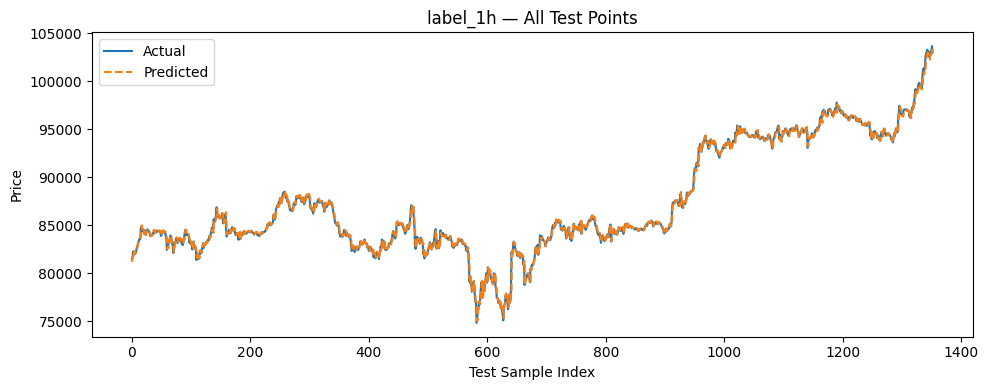

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 836.576	valid_0's l2: 699860
label_2h: RMSE=569.2819, MAPE=0.46%


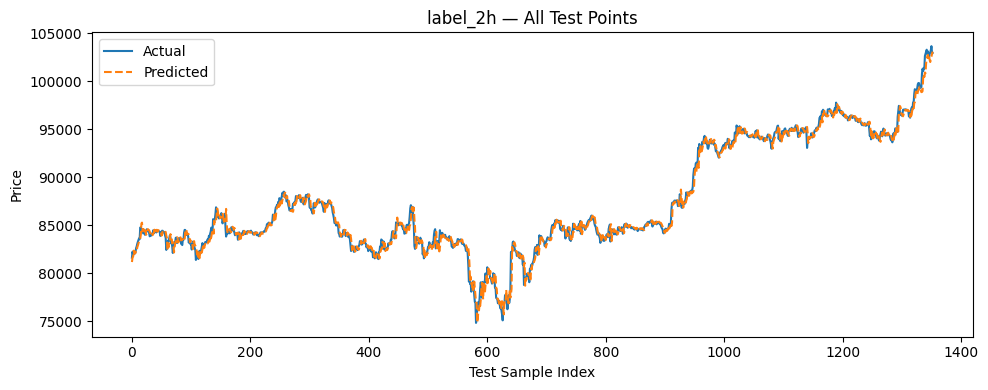

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 1029.3	valid_0's l2: 1.05946e+06
label_3h: RMSE=704.9622, MAPE=0.56%


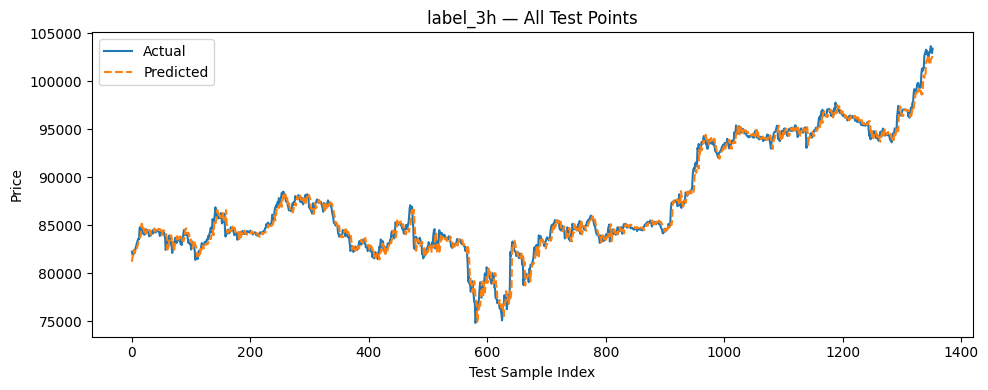

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 1449.6	valid_0's l2: 2.10135e+06
label_6h: RMSE=967.5370, MAPE=0.78%


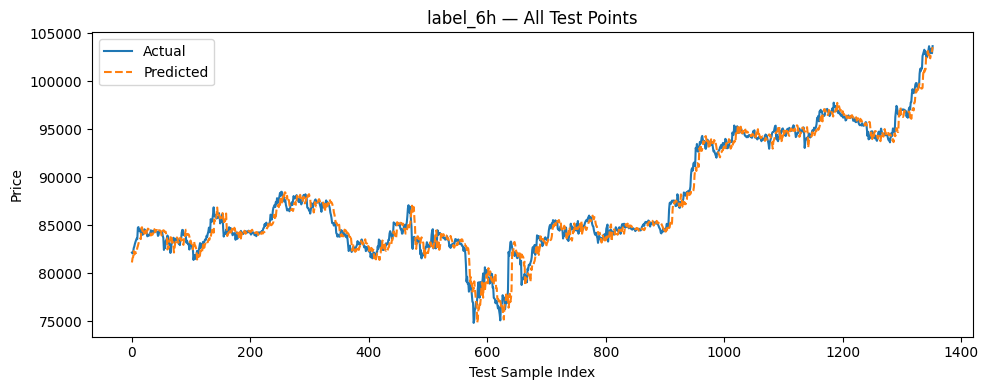

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 1981.14	valid_0's l2: 3.92493e+06
label_12h: RMSE=1428.1038, MAPE=1.24%


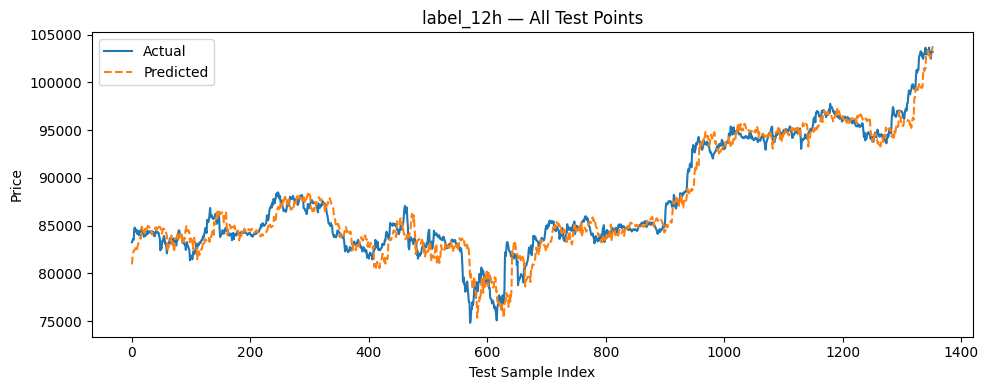

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 2651.31	valid_0's l2: 7.02946e+06
label_1d: RMSE=1991.9179, MAPE=1.65%


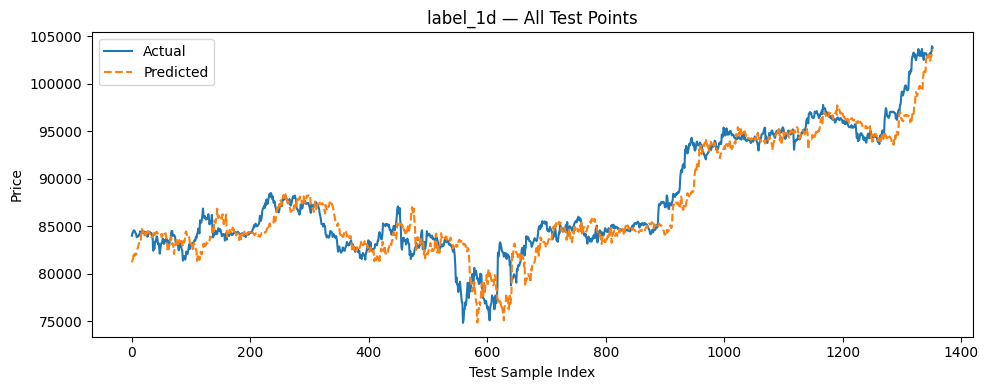

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 3974.75	valid_0's l2: 1.57986e+07
label_3d: RMSE=3453.8631, MAPE=2.97%


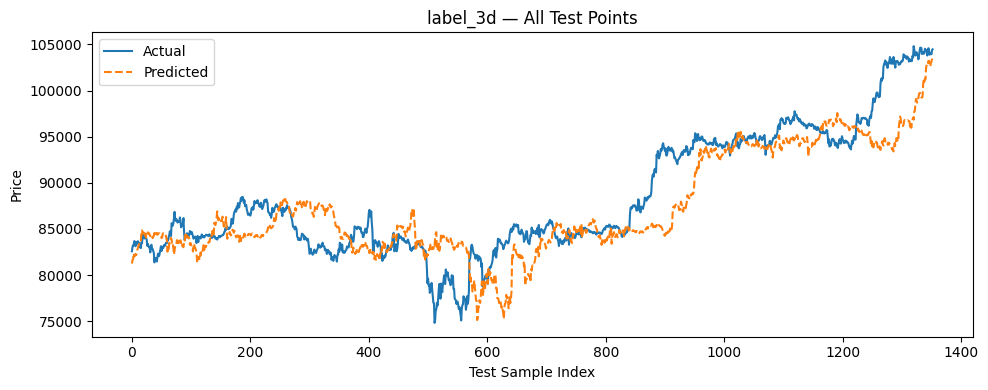

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 5450.47	valid_0's l2: 2.97076e+07
label_7d: RMSE=4919.1804, MAPE=4.26%


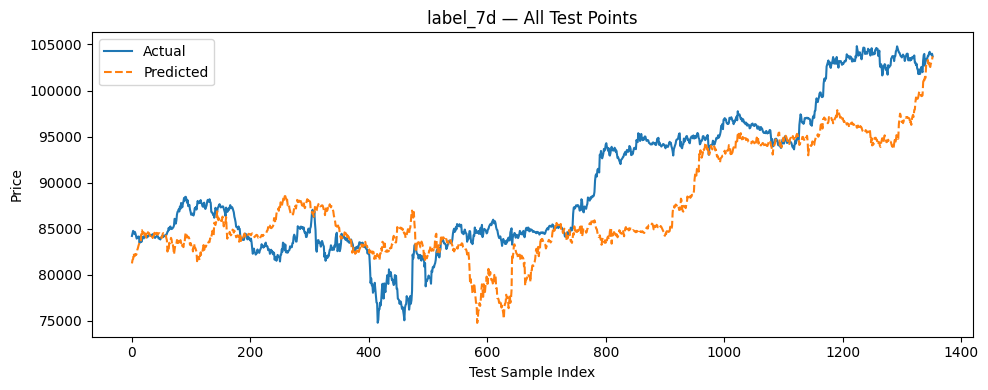

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 7373.44	valid_0's l2: 5.43676e+07
label_15d: RMSE=7937.9896, MAPE=7.07%


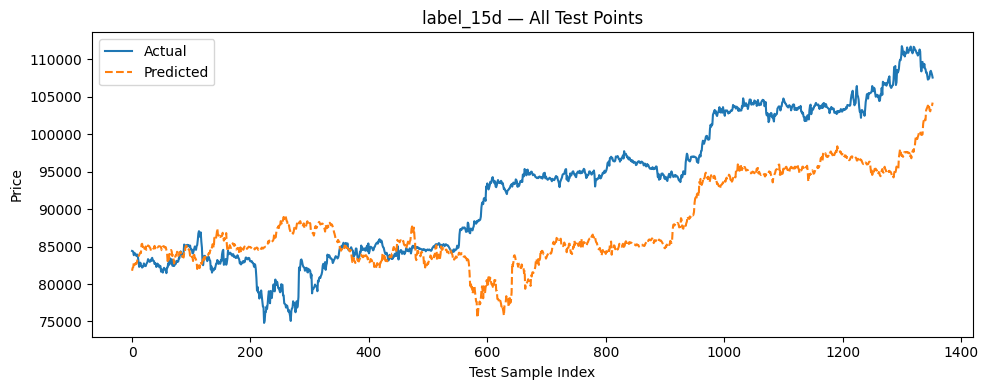

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 10101.2	valid_0's l2: 1.02034e+08
label_30d: RMSE=12989.7702, MAPE=10.90%


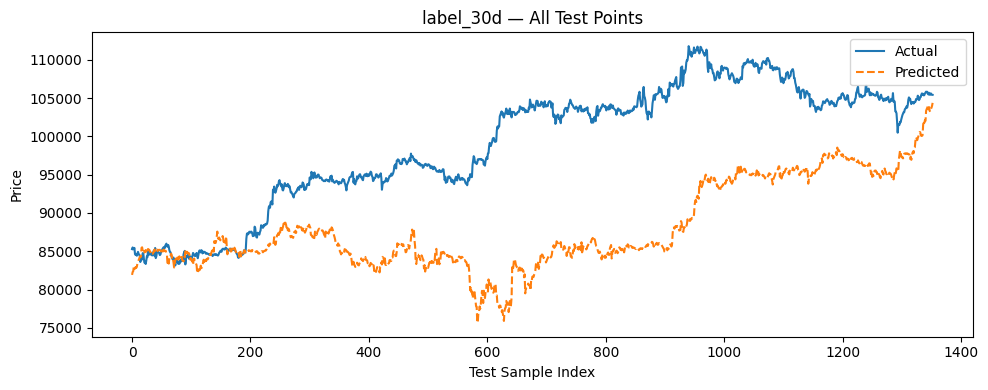

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib

# Paths
TRAIN_CSV = '/kaggle/input/data-btc/fix2/fix2/train.csv'
VAL_CSV   = '/kaggle/input/data-btc/fix2/fix2/val.csv'
TEST_CSV  = '/kaggle/input/data-btc/fix2/fix2/test.csv'

# 1) Load train, val, test
df_tr = pd.read_csv(TRAIN_CSV, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va = pd.read_csv(VAL_CSV,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te = pd.read_csv(TEST_CSV,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) Define horizons & features (exclude labels)
HORIZONS = ['1h','2h','3h','6h','12h','1d','3d','7d','15d','30d']
LABELS   = [f'label_{h}' for h in HORIZONS]
FEATURES = [c for c in df_tr.columns if c not in LABELS]

# 3) Compute STL trend+season for train+val+test
PERIOD     = 24
JUMP       = 24
close_all  = pd.concat([df_tr['close'], df_va['close'], df_te['close']], ignore_index=True)
trend_all  = np.zeros_like(close_all)
season_all = np.zeros_like(close_all)
window_len = PERIOD*2 + 1

for t in range(len(close_all)):
    start = max(0, t - window_len + 1)
    sub   = close_all.iloc[start:t+1]
    dec   = STL(sub, period=PERIOD, trend_jump=JUMP, low_pass_jump=JUMP, robust=True).fit()
    trend_all[t]  = dec.trend.iloc[-1]
    season_all[t] = dec.seasonal.iloc[-1]

n_tr = len(df_tr)
n_va = len(df_va)
trend_tr, trend_va, trend_te     = trend_all[:n_tr], trend_all[n_tr:n_tr+n_va], trend_all[n_tr+n_va:]
season_tr, season_va, season_te = season_all[:n_tr], season_all[n_tr:n_tr+n_va], season_all[n_tr+n_va:]

results = {}

for label in LABELS:
    # residuals
    y_tr = df_tr[label].values - (trend_tr + season_tr)
    y_va = df_va[label].values - (trend_va + season_va)

    # 4) Tuning via early stopping & suppress info
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42,
        verbose=-1               # disable LightGBM info :contentReference[oaicite:0]{index=0}
    )
    model.fit(
        df_tr[FEATURES], y_tr,
        eval_set=[(df_va[FEATURES], y_va)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50),  
            log_evaluation(period=0)            # turn off iteration logs :contentReference[oaicite:1]{index=1}
        ]
    )
    best_it = model.best_iteration_
    best_it = best_it if best_it and best_it > 0 else 100  # fallback

    # 5) Retrain final on train+val
    y_comb = np.concatenate([y_tr, y_va], axis=0)
    df_comb = pd.concat([df_tr, df_va], ignore_index=True)
    final = LGBMRegressor(
        n_estimators=best_it,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
    final.fit(df_comb[FEATURES], y_comb)

    # save model
    # joblib.dump(final, f'LGBM_FINAL_{label}.pkl')

    # 6) Predict & reconstruct price
    y_te_resid = final.predict(df_te[FEATURES])
    y_pred     = trend_te + season_te + y_te_resid
    y_true     = df_te[label].values

    # 7) Print RMSE & MAPE only
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f'{label}: RMSE={rmse:.4f}, MAPE={mape:.2f}%')

    # 8) Plot
    # plt.figure(figsize=(8,3))
    # plt.plot(y_true[:100], label='Actual')
    # plt.plot(y_pred[:100], '--', label='Predicted')
    # plt.title(f'{label}')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # do this:
    plt.figure(figsize=(10, 4))
    plt.plot(y_true,        label='Actual')                 # no slicing :contentReference[oaicite:0]{index=0}
    plt.plot(y_pred, '--',  label='Predicted')
    plt.title(f'{label} — All Test Points')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


ARIMA + LGBM (Final Model)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's rmse: 595.739	valid_0's l2: 354905
label_1h: RMSE=408.45, MAPE=0.32%


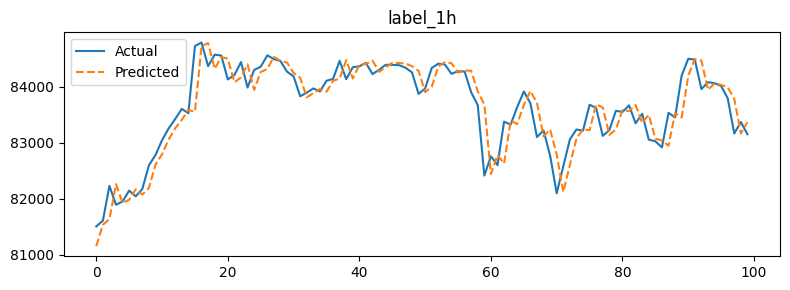

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 595.987	valid_0's l2: 355201
label_2h: RMSE=562.89, MAPE=0.45%


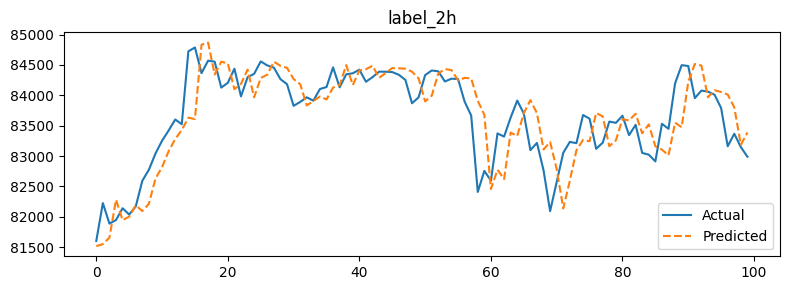

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 596.014	valid_0's l2: 355233
label_3h: RMSE=683.85, MAPE=0.55%


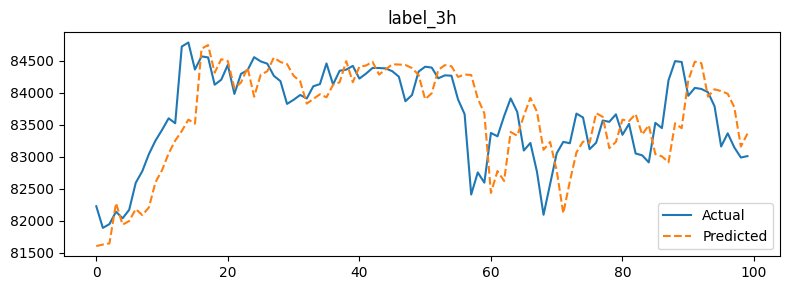

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	valid_0's rmse: 765.901	valid_0's l2: 586604
label_6h: RMSE=990.09, MAPE=0.81%


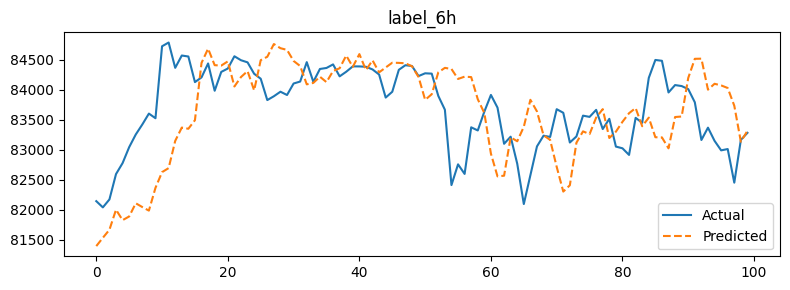

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[214]	valid_0's rmse: 783.883	valid_0's l2: 614473
label_12h: RMSE=1395.10, MAPE=1.16%


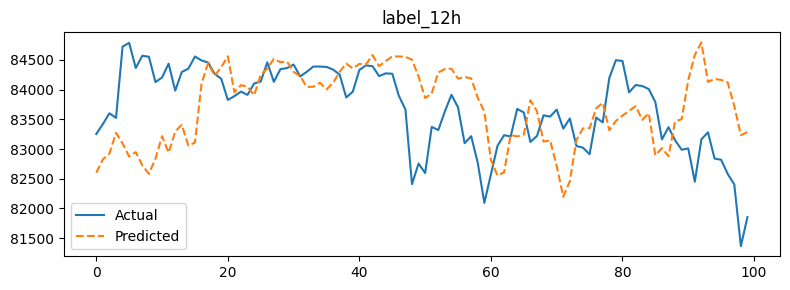

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 820.013	valid_0's l2: 672421
label_1d: RMSE=1957.11, MAPE=1.62%


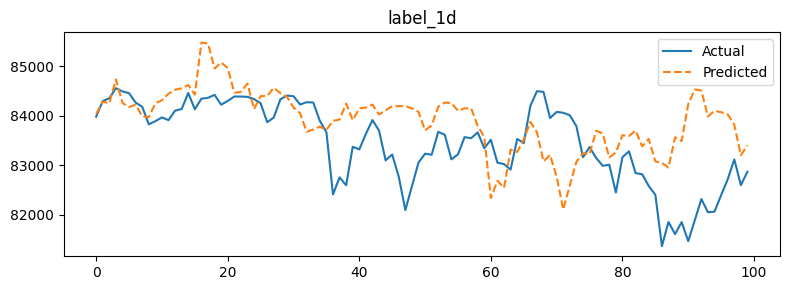

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 774.007	valid_0's l2: 599087
label_3d: RMSE=3454.90, MAPE=2.97%


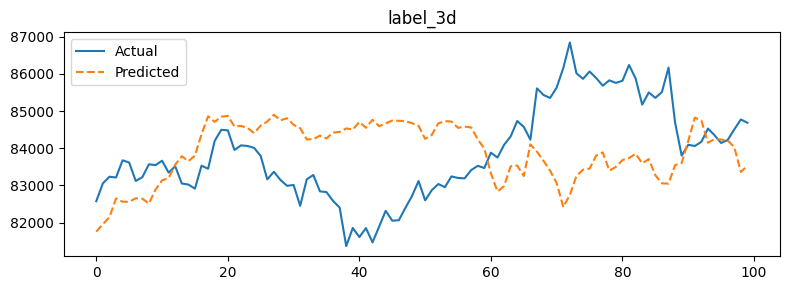

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[354]	valid_0's rmse: 753.196	valid_0's l2: 567304
label_7d: RMSE=4896.85, MAPE=4.27%


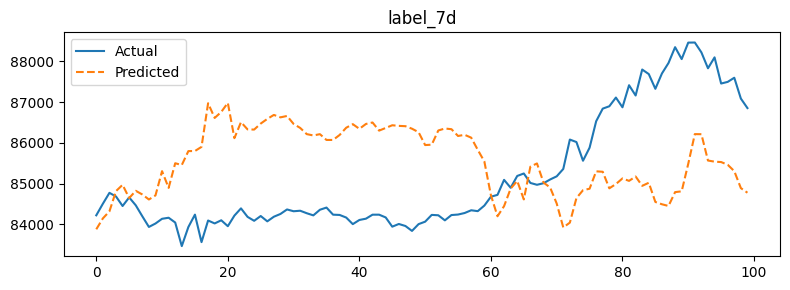

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[237]	valid_0's rmse: 753.845	valid_0's l2: 568282
label_15d: RMSE=8169.11, MAPE=7.46%


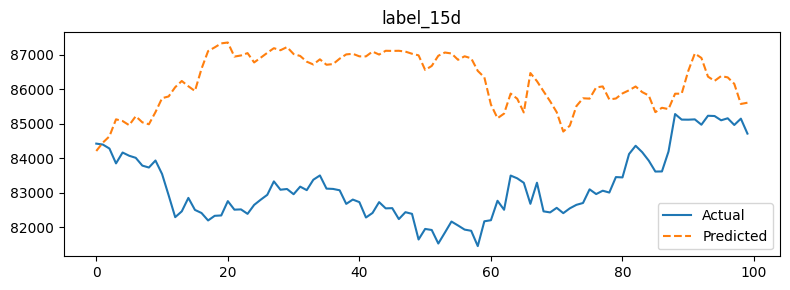

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[186]	valid_0's rmse: 770.936	valid_0's l2: 594342
label_30d: RMSE=12076.29, MAPE=10.14%


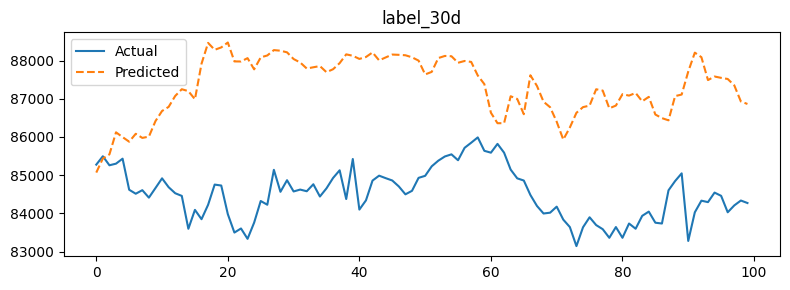

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib

# Paths
TRAIN_CSV = '/kaggle/input/data-btc/fix2/fix2/train.csv'
VAL_CSV   = '/kaggle/input/data-btc/fix2/fix2/val.csv'
TEST_CSV  = '/kaggle/input/data-btc/fix2/fix2/test.csv'

# 1) Load train, val, test
df_tr = pd.read_csv(TRAIN_CSV, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va = pd.read_csv(VAL_CSV,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te = pd.read_csv(TEST_CSV,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) Define horizons & features (exclude labels)
HORIZONS = ['1h','2h','3h','6h','12h','1d','3d','7d','15d','30d']
LABELS   = [f'label_{h}' for h in HORIZONS]
FEATURES = [c for c in df_tr.columns if c not in LABELS]

# 3) Compute STL trend+season
PERIOD     = 24
JUMP       = 24
close_all  = pd.concat([df_tr['close'], df_va['close'], df_te['close']], ignore_index=True)
trend_all  = np.zeros_like(close_all)
season_all = np.zeros_like(close_all)
wnd        = PERIOD*2 + 1

for t in range(len(close_all)):
    sub = close_all.iloc[max(0,t-wnd+1):t+1]
    dec = STL(sub, period=PERIOD, trend_jump=JUMP, low_pass_jump=JUMP, robust=True).fit()
    trend_all[t], season_all[t] = dec.trend.iloc[-1], dec.seasonal.iloc[-1]

n_tr = len(df_tr)
n_va = len(df_va)
trend_tr, trend_va, trend_te   = trend_all[:n_tr], trend_all[n_tr:n_tr+n_va], trend_all[n_tr+n_va:]
season_tr, season_va, season_te= season_all[:n_tr],season_all[n_tr:n_tr+n_va],season_all[n_tr+n_va:]

for label in LABELS:
    # 4) Dekomposisi residual (target minus STL)
    y_tr = df_tr[label].values - (trend_tr + season_tr)
    y_va = df_va[label].values - (trend_va + season_va)
    y_te = df_te[label].values - (trend_te + season_te)

    # 5) FIT ARIMA pada train+val residual
    resid_all = np.concatenate([y_tr, y_va])
    arima = ARIMA(resid_all, order=(2,0,2)).fit()
    # prediksi ARIMA untuk train, val, test
    arima_tr = arima.predict(start=0, end=len(y_tr)-1)
    arima_va = arima.predict(start=len(y_tr), end=len(y_tr)+len(y_va)-1)
    arima_te = arima.predict(start=len(y_tr)+len(y_va), end=len(y_tr)+len(y_va)+len(y_te)-1)

    # 6) Hitung residual baru = (resid - ŷ_arima)
    r_tr = y_tr - arima_tr
    r_va = y_va - arima_va

    # 7) TRAIN LightGBM pada residual baru
    model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, verbose=-1)
    model.fit(
        df_tr[FEATURES], r_tr,
        eval_set=[(df_va[FEATURES], r_va)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=20), log_evaluation(period=0)]
    )
    best_it = model.best_iteration_ or 100
    # retrain full
    df_comb = pd.concat([df_tr, df_va], ignore_index=True)
    r_comb  = np.concatenate([r_tr, r_va])
    final_lgb = LGBMRegressor(n_estimators=best_it, learning_rate=0.05, random_state=42, verbose=-1)
    final_lgb.fit(df_comb[FEATURES], r_comb)

    # 8) PREDIKSI ENSEMBLE pada test
    lgb_te = final_lgb.predict(df_te[FEATURES])
    resid_pred = arima_te + lgb_te
    # reconstruct price: STL trend+season + resid_pred
    y_pred = (trend_te + season_te) + resid_pred
    y_true = df_te[label].values

    # 9) Evaluasi
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f'{label}: RMSE={rmse:.2f}, MAPE={mape:.2f}%')

    # 10) Plot
    plt.figure(figsize=(8,3))
    plt.plot(y_true[:100], label='Actual')
    plt.plot(y_pred[:100], '--', label='Predicted')
    plt.title(f'{label}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # do this:
    # plt.figure(figsize=(10, 4))
    # plt.plot(y_true,        label='Actual')                 # no slicing :contentReference[oaicite:0]{index=0}
    # plt.plot(y_pred, '--',  label='Predicted')
    # plt.title(f'{label} — All Test Points')
    # plt.xlabel('Test Sample Index')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    # 11) Simpan model
    # joblib.dump({'arima': arima, 'lgb': final_lgb}, f'ensemble_{label}.pkl')


LGBM + ARIMA + MHASIL PREDIKSI i untuk prediksi i + 1

In [2]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.4 MB/s eta 0:00:0000:010:01


In [6]:
import warnings
warnings.filterwarnings('ignore')  # suppress FutureWarning, etc.

import pandas as pd
import numpy as np
import pmdarima as pm
import optuna
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import logging
import optuna.logging

# Suppress verbose logs
logging.getLogger('lightgbm').setLevel(logging.WARNING)
logging.getLogger('pmdarima').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Paths to CSV (95% train, 3% val, 2% test splits)
TRAIN_PATH = '/kaggle/input/data-btc/fix2/fix2/train.csv'
VAL_PATH   = '/kaggle/input/data-btc/fix2/fix2/val.csv'
TEST_PATH  = '/kaggle/input/data-btc/fix2/fix2/test.csv'

# 1) Load splits
df_tr_full = pd.read_csv(TRAIN_PATH, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va_full = pd.read_csv(VAL_PATH,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te_full = pd.read_csv(TEST_PATH,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) STL decomposition once on concatenated series
PERIOD = 24
close_all = pd.concat([df_tr_full['close'], df_va_full['close'], df_te_full['close']], ignore_index=True)
stl_res = STL(close_all, period=PERIOD, robust=True).fit()
trend_all, season_all = stl_res.trend.values, stl_res.seasonal.values

# 3) Slice STL for each split
n_tr, n_va = len(df_tr_full), len(df_va_full)
trend_tr, trend_va, trend_te = (trend_all[:n_tr],
                                trend_all[n_tr:n_tr+n_va],
                                trend_all[n_tr+n_va:])
season_tr, season_va, season_te = (season_all[:n_tr],
                                   season_all[n_tr:n_tr+n_va],
                                   season_all[n_tr+n_va:])

# 4) Define horizons (in hours)
horizons = {'1h':1, '2h':2, '3h':3, '6h':6, '12h':12,
            '1d':24, '3d':72, '7d':168, '15d':360, '30d':720}

# Helper: prepare split (shift label and drop last h rows)
def prepare_split(df_full, trend_full, season_full, h):
    df = df_full.copy()
    df['label'] = df['close'].shift(-h)
    df.dropna(subset=['label'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    tr = trend_full[:len(df)]
    se = season_full[:len(df)]
    return df, tr, se

# Main loop per horizon
for label, h in tqdm(horizons.items(), desc='Horizons'):
    # 5) Prepare subsets
    df_tr, tr_tr, se_tr = prepare_split(df_tr_full, trend_tr, season_tr, h)
    df_va, tr_va, se_va = prepare_split(df_va_full, trend_va, season_va, h)
    df_te, tr_te, se_te = prepare_split(df_te_full, trend_te, season_te, h)

    # 6) Combine train+val for history
    df_hist = pd.concat([df_tr, df_va], ignore_index=True)
    tr_hist = np.concatenate([tr_tr, tr_va])
    se_hist = np.concatenate([se_tr, se_va])

    # 7) Tune ARIMA order
    tqdm.write(f'[ARIMA Tune] {label}')
    resid_hist = df_hist['label'].values - (tr_hist + se_hist)
    arima_auto = pm.auto_arima(
        resid_hist, start_p=0, start_q=0, max_p=5, max_q=5,
        seasonal=False, stepwise=True, suppress_warnings=True,
        error_action='ignore', trace=False
    )
    best_order = arima_auto.order
    tqdm.write(f'  best_order = {best_order}')

    # 8) Tune LightGBM via Optuna + TimeSeriesSplit
    tqdm.write(f'[LGBM Tune] {label}')
    FEATURES = [c for c in df_hist.columns if c != 'label']
    X_hist, y_hist = df_hist[FEATURES], resid_hist
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'num_leaves': trial.suggest_int('num_leaves', 16, 128),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'device': 'gpu'  # leverage GPU on Kaggle
        }
        tss = TimeSeriesSplit(n_splits=3)
        mse_list = []
        for tr_idx, va_idx in tss.split(X_hist):
            mdl = LGBMRegressor(random_state=42, **params)
            mdl.fit(X_hist.iloc[tr_idx], y_hist[tr_idx])
            preds = mdl.predict(X_hist.iloc[va_idx])
            mse_list.append(mean_squared_error(y_hist[va_idx], preds))
        return np.mean(mse_list)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    best_lgbm = study.best_trial.params
    tqdm.write(f'  best_lgbm = {best_lgbm}')

    # 9) Walk-forward validation (first 10 points)
    tqdm.write(f'[WFV] {label} (10 pts)')
    preds, trues = [], []
    max_pts = min(10, len(df_te))
    for i in tqdm(range(max_pts), desc=f'WFV {label}'):
        # ARIMA fit & forecast
        resid_curr = df_hist['label'].values - (tr_hist + se_hist)
        arima = ARIMA(resid_curr, order=best_order).fit()
        ar_pred = arima.forecast(1)[0]

        # LGBM fit & predict
        lgbm = LGBMRegressor(random_state=42, **best_lgbm)
        lgbm.fit(df_hist[FEATURES], resid_curr)
        lb_pred = lgbm.predict(df_te[FEATURES].iloc[[i]])[0]

        # combine
        forecast = (tr_te[i] + se_te[i]) + ar_pred + lb_pred
        preds.append(forecast)
        trues.append(df_te['label'].iloc[i])

        # update history with ground truth
        new_row = df_te.iloc[[i]].copy()
        df_hist = pd.concat([df_hist, new_row], ignore_index=True)
        tr_hist = np.append(tr_hist, tr_te[i])
        se_hist = np.append(se_hist, se_te[i])

    # 10) Report metrics
    rmse = mean_squared_error(trues, preds, squared=False)
    mape = mean_absolute_percentage_error(trues, preds) * 100
    tqdm.write(f'{label}: RMSE={rmse:.2f}, MAPE={mape:.2f}%\n')


Horizons:   0%|          | 0/10 [00:00<?, ?it/s]

[ARIMA Tune] 1h


Horizons:   0%|          | 0/10 [00:37<?, ?it/s]

  best_order = (4, 0, 0)
[LGBM Tune] 1h


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
Horizons:   0%|          | 0/10 [02:31<?, ?it/s]

  best_lgbm = {'n_estimators': 101, 'num_leaves': 118, 'max_depth': 11, 'learning_rate': 0.001026266206234645, 'feature_fraction': 0.6154738395014347, 'bagging_fraction': 0.9934833895154183, 'min_child_samples': 32}
[WFV] 1h (10 pts)



Horizons:  10%|█         | 1/10 [03:14<29:10, 194.45s/it]

1h: RMSE=205.29, MAPE=0.21%

[ARIMA Tune] 2h


Horizons:  10%|█         | 1/10 [04:04<29:10, 194.45s/it]

  best_order = (4, 0, 0)
[LGBM Tune] 2h


Horizons:  10%|█         | 1/10 [05:22<29:10, 194.45s/it]

  best_lgbm = {'n_estimators': 139, 'num_leaves': 51, 'max_depth': 7, 'learning_rate': 0.0010262406033948793, 'feature_fraction': 0.8107910529054027, 'bagging_fraction': 0.7240230670731543, 'min_child_samples': 42}
[WFV] 2h (10 pts)



Horizons:  20%|██        | 2/10 [06:02<23:50, 178.75s/it]

2h: RMSE=343.62, MAPE=0.30%

[ARIMA Tune] 3h


Horizons:  20%|██        | 2/10 [06:41<23:50, 178.75s/it]

  best_order = (5, 0, 0)
[LGBM Tune] 3h


Horizons:  20%|██        | 2/10 [08:17<23:50, 178.75s/it]

  best_lgbm = {'n_estimators': 388, 'num_leaves': 31, 'max_depth': 3, 'learning_rate': 0.0011618059632184893, 'feature_fraction': 0.6050222249078431, 'bagging_fraction': 0.9251407328418393, 'min_child_samples': 19}
[WFV] 3h (10 pts)



Horizons:  30%|███       | 3/10 [09:08<21:16, 182.36s/it]

3h: RMSE=368.39, MAPE=0.36%

[ARIMA Tune] 6h


Horizons:  30%|███       | 3/10 [09:37<21:16, 182.36s/it]

  best_order = (5, 0, 0)
[LGBM Tune] 6h


Horizons:  30%|███       | 3/10 [10:56<21:16, 182.36s/it]

  best_lgbm = {'n_estimators': 332, 'num_leaves': 16, 'max_depth': 3, 'learning_rate': 0.0012244462388947528, 'feature_fraction': 0.8101461958252524, 'bagging_fraction': 0.7317363281755468, 'min_child_samples': 7}
[WFV] 6h (10 pts)



Horizons:  40%|████      | 4/10 [11:46<17:14, 172.44s/it]

6h: RMSE=438.61, MAPE=0.47%

[ARIMA Tune] 12h


Horizons:  40%|████      | 4/10 [12:28<17:14, 172.44s/it]

  best_order = (4, 0, 0)
[LGBM Tune] 12h


Horizons:  40%|████      | 4/10 [13:52<17:14, 172.44s/it]

  best_lgbm = {'n_estimators': 104, 'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.001012697864252373, 'feature_fraction': 0.98934530747427, 'bagging_fraction': 0.6480058864999946, 'min_child_samples': 5}
[WFV] 12h (10 pts)



Horizons:  50%|█████     | 5/10 [14:29<14:06, 169.27s/it]

12h: RMSE=562.96, MAPE=0.52%

[ARIMA Tune] 1d


Horizons:  50%|█████     | 5/10 [40:04<40:04, 480.88s/it]


KeyboardInterrupt: 

lgbm + sarima

Horizons:   0%|          | 0/10 [00:00<?, ?it/s]

[ARIMA] Tuning 1h


Horizons:   0%|          | 0/10 [02:01<?, ?it/s]

  order=(3, 0, 2), seasonal=(0, 0, 0, 0)
[LGBM ] Tuning 1h


Horizons:   0%|          | 0/10 [02:54<?, ?it/s]

  best_lgbm={'n_estimators': 105, 'num_leaves': 41, 'max_depth': 3, 'learning_rate': 0.0010643867788833951, 'feature_fraction': 0.6941615539840065, 'bagging_fraction': 0.9985295196004006, 'min_child_samples': 6}
[WFV  ] 1h (10 pts)



WFV 1h: 100%|██████████| 10/10 [05:31<00:00, 33.10s/it]


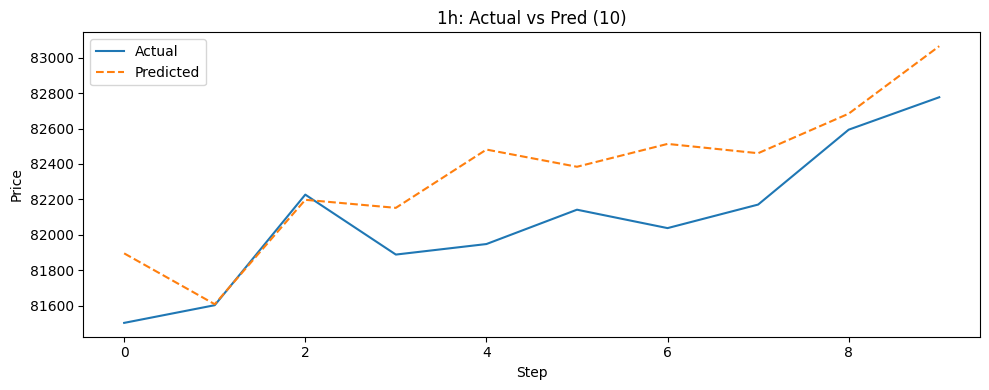

Horizons:  10%|█         | 1/10 [08:25<1:15:47, 505.31s/it]

1h: RMSE=311.14, MAPE=0.32%

[ARIMA] Tuning 2h


Horizons:  10%|█         | 1/10 [11:35<1:15:47, 505.31s/it]

  order=(3, 0, 2), seasonal=(0, 0, 0, 0)
[LGBM ] Tuning 2h


Horizons:  10%|█         | 1/10 [12:28<1:15:47, 505.31s/it]

  best_lgbm={'n_estimators': 119, 'num_leaves': 48, 'max_depth': 3, 'learning_rate': 0.0010188118861910308, 'feature_fraction': 0.7141744717434966, 'bagging_fraction': 0.727916139765207, 'min_child_samples': 10}
[WFV  ] 2h (10 pts)



WFV 2h: 100%|██████████| 10/10 [07:13<00:00, 43.32s/it]


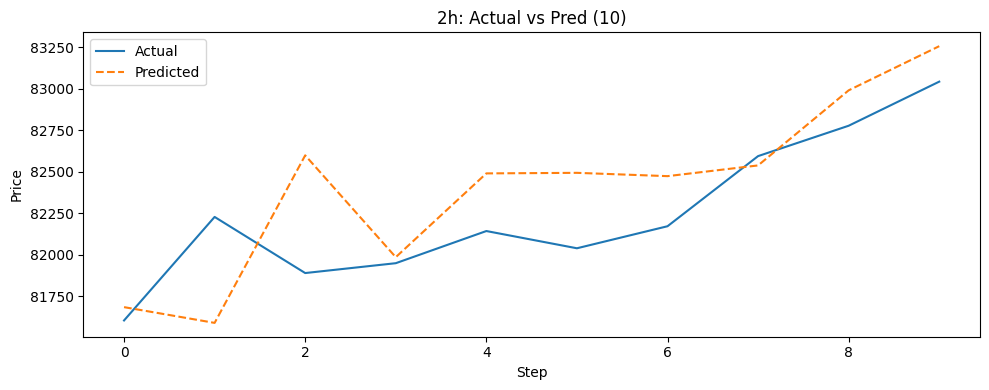

Horizons:  20%|██        | 2/10 [19:42<1:20:50, 606.29s/it]

2h: RMSE=378.31, MAPE=0.37%

[ARIMA] Tuning 3h


Horizons:  20%|██        | 2/10 [21:34<1:20:50, 606.29s/it]

  order=(3, 0, 3), seasonal=(0, 0, 0, 0)
[LGBM ] Tuning 3h


Horizons:  20%|██        | 2/10 [22:19<1:20:50, 606.29s/it]

  best_lgbm={'n_estimators': 101, 'num_leaves': 50, 'max_depth': 7, 'learning_rate': 0.0010375939115548525, 'feature_fraction': 0.6018839145668768, 'bagging_fraction': 0.7918907115868119, 'min_child_samples': 30}
[WFV  ] 3h (10 pts)



WFV 3h: 100%|██████████| 10/10 [04:52<00:00, 29.28s/it]


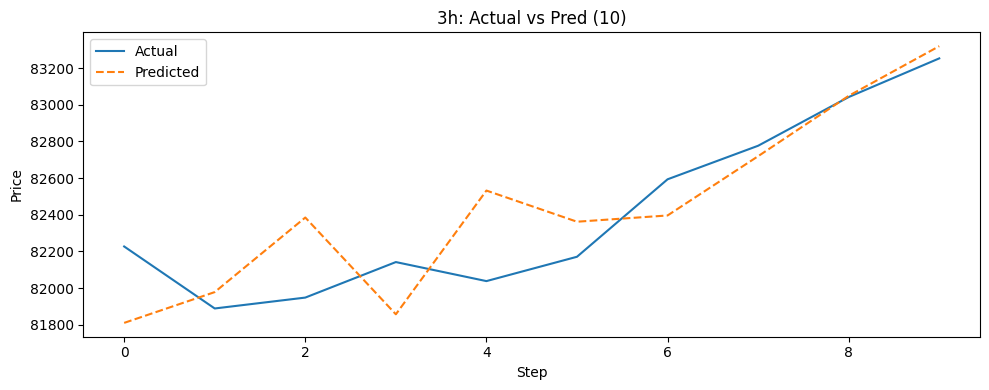

Horizons:  30%|███       | 3/10 [27:12<1:02:25, 535.05s/it]

3h: RMSE=279.46, MAPE=0.27%

[ARIMA] Tuning 6h


Horizons:  30%|███       | 3/10 [31:13<1:02:25, 535.05s/it]

  order=(3, 0, 3), seasonal=(0, 0, 0, 0)
[LGBM ] Tuning 6h


Horizons:  30%|███       | 3/10 [32:02<1:02:25, 535.05s/it]

  best_lgbm={'n_estimators': 102, 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.0010177685767148725, 'feature_fraction': 0.7363652617889684, 'bagging_fraction': 0.9857261355065391, 'min_child_samples': 23}
[WFV  ] 6h (10 pts)



WFV 6h: 100%|██████████| 10/10 [13:22<00:00, 80.25s/it]


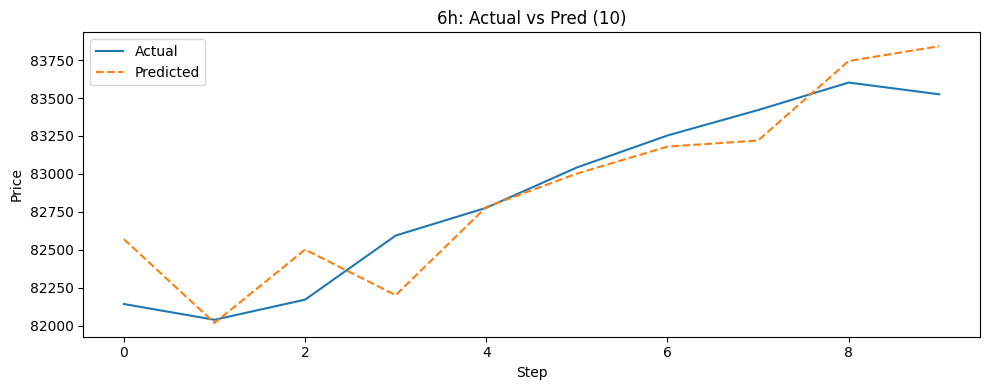

Horizons:  40%|████      | 4/10 [45:25<1:15:32, 755.36s/it]

6h: RMSE=247.86, MAPE=0.24%

[ARIMA] Tuning 12h


Horizons:  40%|████      | 4/10 [46:14<1:15:32, 755.36s/it]

  order=(2, 0, 1), seasonal=(0, 0, 0, 0)
[LGBM ] Tuning 12h


Horizons:  40%|████      | 4/10 [47:01<1:15:32, 755.36s/it]

  best_lgbm={'n_estimators': 107, 'num_leaves': 30, 'max_depth': 3, 'learning_rate': 0.0011815766867127842, 'feature_fraction': 0.6021665170030702, 'bagging_fraction': 0.9755540445897278, 'min_child_samples': 6}
[WFV  ] 12h (10 pts)



WFV 12h: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


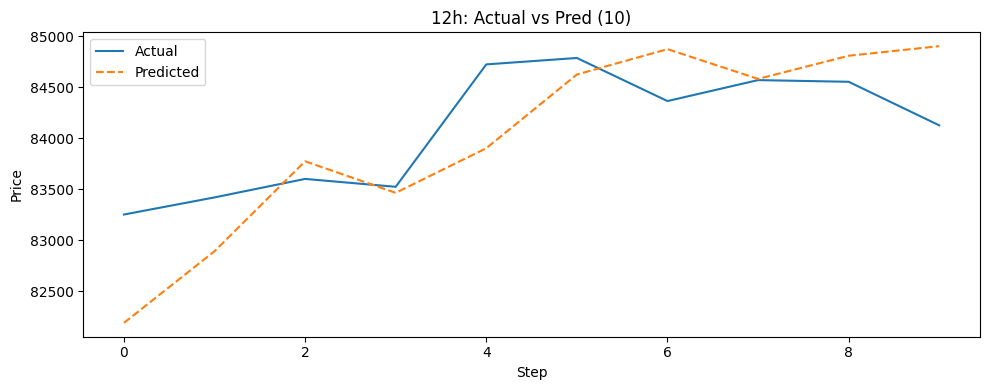

Horizons:  50%|█████     | 5/10 [47:42<44:21, 532.34s/it]  

12h: RMSE=553.80, MAPE=0.52%

[ARIMA] Tuning 1d


In [ ]:
import warnings
warnings.filterwarnings('ignore')  # suppress all warnings

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)
logging.getLogger('pmdarima').setLevel(logging.WARNING)
logging.getLogger('statsmodels').setLevel(logging.ERROR)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Paths to pre-split CSVs ---
TRAIN_PATH = '/kaggle/input/data-btc/fix2/fix2/train.csv'
VAL_PATH   = '/kaggle/input/data-btc/fix2/fix2/val.csv'
TEST_PATH  = '/kaggle/input/data-btc/fix2/fix2/test.csv'

# 1) Load splits
df_tr_full = pd.read_csv(TRAIN_PATH, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va_full = pd.read_csv(VAL_PATH,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te_full = pd.read_csv(TEST_PATH,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) STL decomposition once
PERIOD = 24  # daily seasonality in hourly data
close_all = pd.concat([df_tr_full['close'], df_va_full['close'], df_te_full['close']], ignore_index=True)
stl = STL(close_all, period=PERIOD, robust=True).fit()
trend_all = stl.trend.values
season_all= stl.seasonal.values

# 3) Slice STL into splits
n_tr = len(df_tr_full); n_va = len(df_va_full)
trend_tr, trend_va, trend_te = trend_all[:n_tr], trend_all[n_tr:n_tr+n_va], trend_all[n_tr+n_va:]
season_tr, season_va, season_te = season_all[:n_tr], season_all[n_tr:n_tr+n_va], season_all[n_tr+n_va:]

# 4) Define horizons
horizons = {'1h':1, '2h':2, '3h':3, '6h':6, '12h':12,
            '1d':24, '3d':72, '7d':168, '15d':360, '30d':720}

# Helper: shift label and drop last h rows
def prepare_split(df_full, tr_full, se_full, h):
    df = df_full.copy()
    df['label'] = df['close'].shift(-h)
    df.dropna(subset=['label'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df, tr_full[:len(df)], se_full[:len(df)]

# --- Main loop per horizon ---
for label, h in tqdm(horizons.items(), desc='Horizons'):
    # Prepare data subsets
    df_tr, tr_tr, se_tr = prepare_split(df_tr_full, trend_tr,  season_tr,  h)
    df_va, tr_va, se_va = prepare_split(df_va_full, trend_va,  season_va,  h)
    df_te, tr_te, se_te = prepare_split(df_te_full, trend_te,  season_te,  h)

    # Combine train+val history
    df_hist = pd.concat([df_tr, df_va], ignore_index=True)
    tr_hist = np.concatenate([tr_tr, tr_va])
    se_hist = np.concatenate([se_tr, se_va])

    # --- ARIMA/SARIMA tuning with limited search ---
    tqdm.write(f'[ARIMA] Tuning {label}')
    resid_hist = df_hist['label'].values - (tr_hist + se_hist)
    if h < PERIOD:
        # short horizon: non-seasonal ARIMA, restrict to p,q <= 3
        arima_auto = pm.auto_arima(
            resid_hist,
            start_p=0, start_q=0, max_p=3, max_q=3,
            seasonal=False,
            stepwise=True, suppress_warnings=True,
            error_action='ignore', trace=False
        )
        best_order = arima_auto.order
        seasonal_order = (0,0,0,0)
    else:
        # longer horizon: SARIMA with limited seasonal search
        arima_auto = pm.auto_arima(
            resid_hist,
            start_p=0, start_q=0, max_p=3, max_q=3,
            seasonal=True, m=PERIOD,
            start_P=0, start_Q=0, max_P=2, max_Q=2,
            stepwise=True, suppress_warnings=True,
            error_action='ignore', trace=False
        )
        best_order = arima_auto.order
        seasonal_order = arima_auto.seasonal_order
    tqdm.write(f'  order={best_order}, seasonal={seasonal_order}')

    # --- LightGBM tuning (unchanged) ---
    tqdm.write(f'[LGBM ] Tuning {label}')
    FEATURES = [c for c in df_hist.columns if c != 'label']
    X_hist, y_hist = df_hist[FEATURES], resid_hist
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'num_leaves':    trial.suggest_int('num_leaves', 16, 64),
            'max_depth':     trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
            'verbose': -1, 'device': 'gpu'
        }
        tss = TimeSeriesSplit(n_splits=3)
        mses = []
        for tr_idx, va_idx in tss.split(X_hist):
            mdl = LGBMRegressor(random_state=42, **params)
            mdl.fit(X_hist.iloc[tr_idx], y_hist[tr_idx])
            preds = mdl.predict(X_hist.iloc[va_idx])
            mses.append(mean_squared_error(y_hist[va_idx], preds))
        return np.mean(mses)
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=15, show_progress_bar=False)
    best_lgbm = study.best_trial.params
    tqdm.write(f'  best_lgbm={best_lgbm}')

    # --- Walk-forward: predict first 10 test points ---
    tqdm.write(f'[WFV  ] {label} (10 pts)')
    preds, trues = [], []
    max_pts = min(10, len(df_te))
    for i in tqdm(range(max_pts), desc=f'WFV {label}'):
        resid_curr = df_hist['label'].values - (tr_hist + se_hist)
        if seasonal_order != (0,0,0,0):
            model_ts = SARIMAX(resid_curr, order=best_order, seasonal_order=seasonal_order).fit()
        else:
            model_ts = ARIMA(resid_curr, order=best_order).fit()
        ar_pred = model_ts.forecast(1)[0]

        lgbm = LGBMRegressor(random_state=42, **best_lgbm)
        lgbm.fit(df_hist[FEATURES], resid_curr)
        lb_pred = lgbm.predict(df_te[FEATURES].iloc[[i]])[0]

        forecast = (tr_te[i] + se_te[i]) + ar_pred + lb_pred
        preds.append(forecast);
        trues.append(df_te['label'].iloc[i])

        new_row = df_te.iloc[[i]].copy()
        df_hist = pd.concat([df_hist, new_row], ignore_index=True)
        tr_hist = np.append(tr_hist, tr_te[i])
        se_hist = np.append(se_hist, se_te[i])

    # Plot results
    plt.figure(figsize=(10,4))
    plt.plot(trues, label='Actual')
    plt.plot(preds, '--', label='Predicted')
    plt.title(f'{label}: Actual vs Pred (10)')
    plt.xlabel('Step'); plt.ylabel('Price')
    plt.legend(); plt.tight_layout(); plt.show()

    rmse = mean_squared_error(trues, preds, squared=False)
    mape = mean_absolute_percentage_error(trues, preds)*100
    tqdm.write(f'{label}: RMSE={rmse:.2f}, MAPE={mape:.2f}%\n')


Horizons:   0%|          | 0/10 [00:00<?, ?it/s]


--- 1h TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  81503.31
1  81503.31  81603.08
2  81603.08  82226.98
3  82226.98  81888.77
4  81888.77  81948.16
5  81948.16  82141.96
6  82141.96  82038.09
7  82038.09  82170.85
8  82170.85  82593.44
9  82593.44  82776.50


Horizons:   0%|          | 0/10 [00:11<?, ?it/s]

[LGBM Tune] 1h


Horizons:   0%|          | 0/10 [01:16<?, ?it/s]

  best_lgbm = {'n_estimators': 369, 'num_leaves': 58, 'max_depth': 7, 'learning_rate': 0.07121394495275275, 'feature_fraction': 0.9635304563755145, 'bagging_fraction': 0.7821301574816163, 'min_child_samples': 21}
[WFV] 1h (10 pts)



WFV 1h: 100%|██████████| 10/10 [01:56<00:00, 11.66s/it]


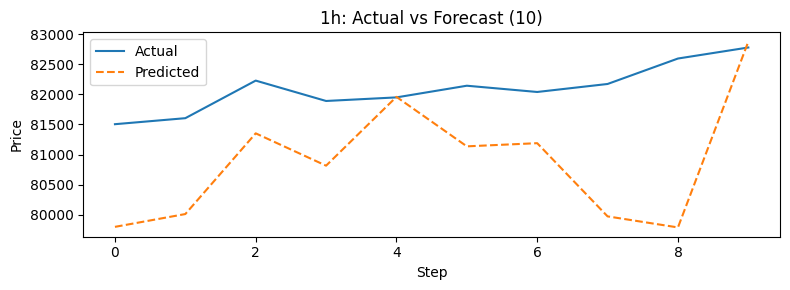

Horizons:  10%|█         | 1/10 [03:13<29:04, 193.82s/it]

1h: RMSE=1476.29, MAPE=1.49%


--- 2h TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  81603.08
1  81503.31  82226.98
2  81603.08  81888.77
3  82226.98  81948.16
4  81888.77  82141.96
5  81948.16  82038.09
6  82141.96  82170.85
7  82038.09  82593.44
8  82170.85  82776.50
9  82593.44  83042.22


Horizons:  10%|█         | 1/10 [03:24<29:04, 193.82s/it]

[LGBM Tune] 2h


Horizons:  10%|█         | 1/10 [04:22<29:04, 193.82s/it]

  best_lgbm = {'n_estimators': 495, 'num_leaves': 30, 'max_depth': 4, 'learning_rate': 0.0541614034083158, 'feature_fraction': 0.9404666927719655, 'bagging_fraction': 0.8793287103437577, 'min_child_samples': 25}
[WFV] 2h (10 pts)



WFV 2h: 100%|██████████| 10/10 [01:49<00:00, 10.96s/it]


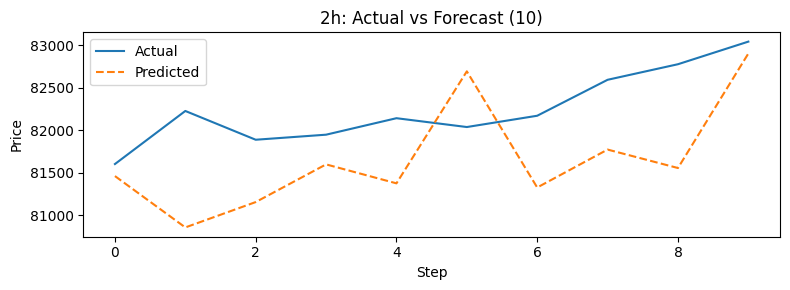

Horizons:  20%|██        | 2/10 [06:12<24:36, 184.62s/it]

2h: RMSE=803.84, MAPE=0.86%


--- 3h TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  82226.98
1  81503.31  81888.77
2  81603.08  81948.16
3  82226.98  82141.96
4  81888.77  82038.09
5  81948.16  82170.85
6  82141.96  82593.44
7  82038.09  82776.50
8  82170.85  83042.22
9  82593.44  83253.15


Horizons:  20%|██        | 2/10 [06:22<24:36, 184.62s/it]

[LGBM Tune] 3h


Horizons:  20%|██        | 2/10 [07:11<24:36, 184.62s/it]

  best_lgbm = {'n_estimators': 299, 'num_leaves': 55, 'max_depth': 4, 'learning_rate': 0.05498596766342344, 'feature_fraction': 0.9446857934270715, 'bagging_fraction': 0.8632248470097339, 'min_child_samples': 9}
[WFV] 3h (10 pts)



WFV 3h: 100%|██████████| 10/10 [01:46<00:00, 10.66s/it]


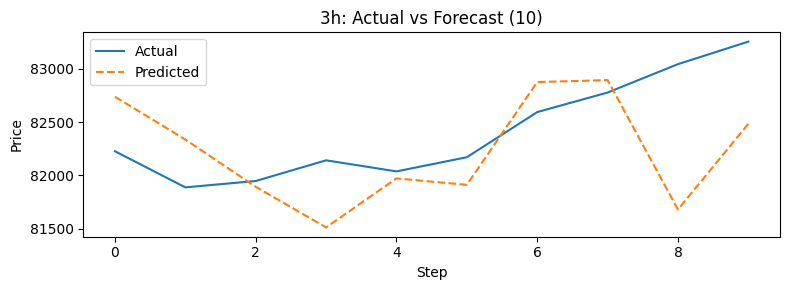

Horizons:  30%|███       | 3/10 [08:58<20:32, 176.13s/it]

3h: RMSE=588.71, MAPE=0.54%


--- 6h TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  82141.96
1  81503.31  82038.09
2  81603.08  82170.85
3  82226.98  82593.44
4  81888.77  82776.50
5  81948.16  83042.22
6  82141.96  83253.15
7  82038.09  83420.87
8  82170.85  83602.16
9  82593.44  83524.80


Horizons:  30%|███       | 3/10 [09:08<20:32, 176.13s/it]

[LGBM Tune] 6h


Horizons:  30%|███       | 3/10 [09:56<20:32, 176.13s/it]

  best_lgbm = {'n_estimators': 163, 'num_leaves': 16, 'max_depth': 4, 'learning_rate': 0.03535124394597877, 'feature_fraction': 0.961614364408775, 'bagging_fraction': 0.8307968681790545, 'min_child_samples': 15}
[WFV] 6h (10 pts)



WFV 6h: 100%|██████████| 10/10 [01:45<00:00, 10.55s/it]


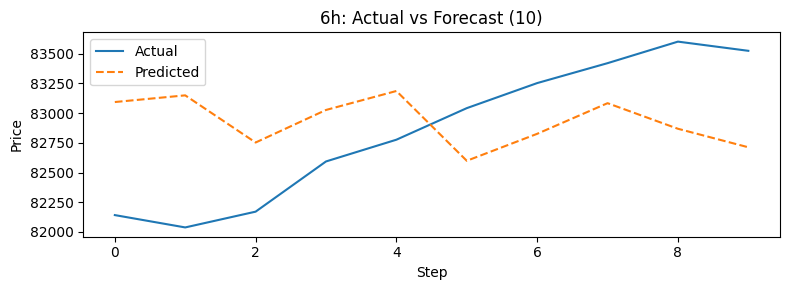

Horizons:  40%|████      | 4/10 [11:42<17:08, 171.40s/it]

6h: RMSE=672.77, MAPE=0.75%


--- 12h TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  83253.15
1  81503.31  83420.87
2  81603.08  83602.16
3  82226.98  83524.80
4  81888.77  84724.58
5  81948.16  84787.37
6  82141.96  84365.18
7  82038.09  84570.54
8  82170.85  84554.00
9  82593.44  84127.20


Horizons:  40%|████      | 4/10 [11:52<17:08, 171.40s/it]

[LGBM Tune] 12h


Horizons:  40%|████      | 4/10 [12:44<17:08, 171.40s/it]

  best_lgbm = {'n_estimators': 391, 'num_leaves': 33, 'max_depth': 3, 'learning_rate': 0.005675080233712554, 'feature_fraction': 0.613255456613379, 'bagging_fraction': 0.9947385101228037, 'min_child_samples': 13}
[WFV] 12h (10 pts)



WFV 12h: 100%|██████████| 10/10 [01:46<00:00, 10.60s/it]


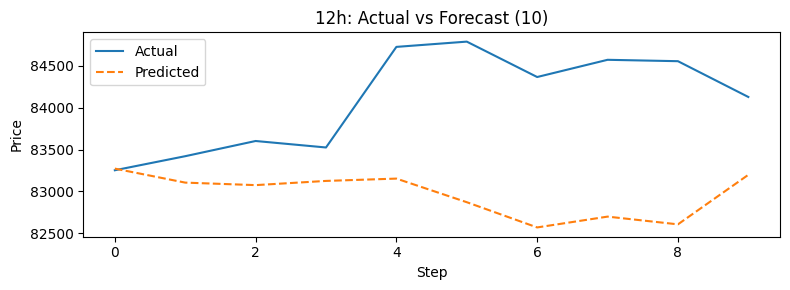

Horizons:  50%|█████     | 5/10 [14:31<14:12, 170.53s/it]

12h: RMSE=1342.98, MAPE=1.34%


--- 1d TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  83983.20
1  81503.31  84297.14
2  81603.08  84353.85
3  82226.98  84557.95
4  81888.77  84491.99
5  81948.16  84456.57
6  82141.96  84266.26
7  82038.09  84183.28
8  82170.85  83827.31
9  82593.44  83891.36


Horizons:  50%|█████     | 5/10 [14:41<14:12, 170.53s/it]

[LGBM Tune] 1d


Horizons:  50%|█████     | 5/10 [15:26<14:12, 170.53s/it]

  best_lgbm = {'n_estimators': 228, 'num_leaves': 16, 'max_depth': 10, 'learning_rate': 0.001049279019748581, 'feature_fraction': 0.6532321798582348, 'bagging_fraction': 0.7031786906282743, 'min_child_samples': 30}
[WFV] 1d (10 pts)



WFV 1d: 100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


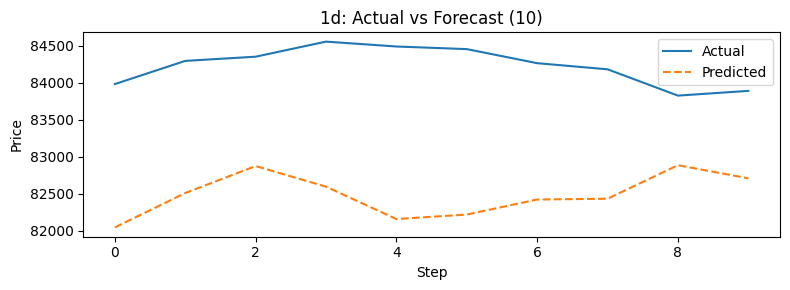

Horizons:  60%|██████    | 6/10 [17:11<11:08, 167.05s/it]

1d: RMSE=1795.42, MAPE=2.07%


--- 3d TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  82574.53
1  81503.31  83054.91
2  81603.08  83233.80
3  82226.98  83212.51
4  81888.77  83675.65
5  81948.16  83615.53
6  82141.96  83120.00
7  82038.09  83220.91
8  82170.85  83567.87
9  82593.44  83547.17


Horizons:  60%|██████    | 6/10 [17:21<11:08, 167.05s/it]

[LGBM Tune] 3d


Horizons:  60%|██████    | 6/10 [18:08<11:08, 167.05s/it]

  best_lgbm = {'n_estimators': 102, 'num_leaves': 25, 'max_depth': 3, 'learning_rate': 0.0010383933452216075, 'feature_fraction': 0.7230939824864947, 'bagging_fraction': 0.7299972341027988, 'min_child_samples': 10}
[WFV] 3d (10 pts)



WFV 3d: 100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


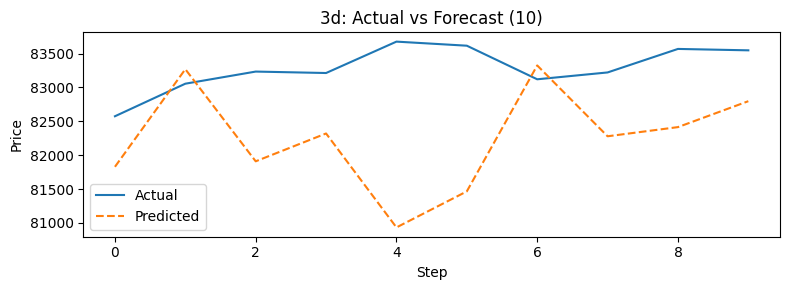

Horizons:  70%|███████   | 7/10 [19:49<08:11, 163.98s/it]

3d: RMSE=1345.62, MAPE=1.33%


--- 7d TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  84223.39
1  81503.31  84507.07
2  81603.08  84775.07
3  82226.98  84685.40
4  81888.77  84451.96
5  81948.16  84662.74
6  82141.96  84469.66
7  82038.09  84200.00
8  82170.85  83937.98
9  82593.44  84022.32


Horizons:  70%|███████   | 7/10 [19:59<08:11, 163.98s/it]

[LGBM Tune] 7d


Horizons:  70%|███████   | 7/10 [20:42<08:11, 163.98s/it]

  best_lgbm = {'n_estimators': 169, 'num_leaves': 22, 'max_depth': 9, 'learning_rate': 0.0010978676076843655, 'feature_fraction': 0.7744714170862601, 'bagging_fraction': 0.9991940742937179, 'min_child_samples': 5}
[WFV] 7d (10 pts)



WFV 7d: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


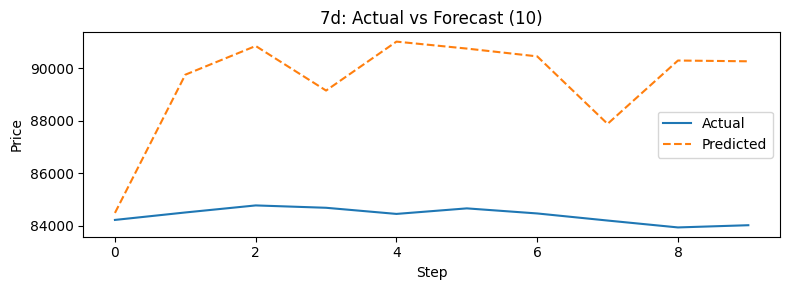

Horizons:  80%|████████  | 8/10 [22:25<05:22, 161.47s/it]

7d: RMSE=5407.43, MAPE=6.03%


--- 15d TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  84424.38
1  81503.31  84396.89
2  81603.08  84281.90
3  82226.98  83851.40
4  81888.77  84166.30
5  81948.16  84072.96
6  82141.96  84012.64
7  82038.09  83787.28
8  82170.85  83731.82
9  82593.44  83934.95


Horizons:  80%|████████  | 8/10 [22:35<05:22, 161.47s/it]

[LGBM Tune] 15d


Horizons:  80%|████████  | 8/10 [23:15<05:22, 161.47s/it]

  best_lgbm = {'n_estimators': 173, 'num_leaves': 30, 'max_depth': 5, 'learning_rate': 0.0010378730882373843, 'feature_fraction': 0.9114444715603199, 'bagging_fraction': 0.655015454628212, 'min_child_samples': 24}
[WFV] 15d (10 pts)



WFV 15d: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


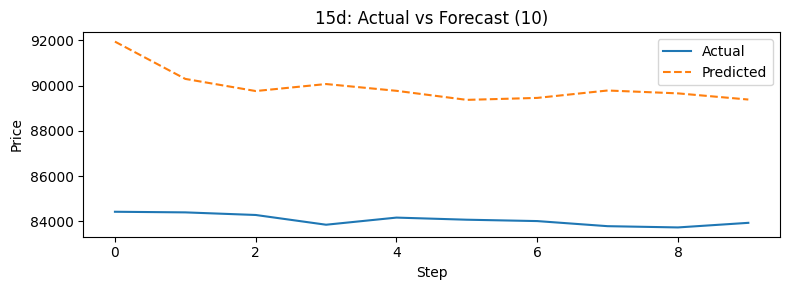

Horizons:  90%|█████████ | 9/10 [24:57<02:38, 158.64s/it]

15d: RMSE=5913.44, MAPE=7.00%


--- 30d TEST VERIFICATION (first 10 rows) ---
      close     label
0  81115.78  85276.90
1  81503.31  85495.72
2  81603.08  85259.77
3  82226.98  85302.22
4  81888.77  85432.31
5  81948.16  84619.98
6  82141.96  84515.58
7  82038.09  84608.69
8  82170.85  84413.10
9  82593.44  84664.60


Horizons:  90%|█████████ | 9/10 [25:07<02:38, 158.64s/it]

[LGBM Tune] 30d


Horizons:  90%|█████████ | 9/10 [25:58<02:38, 158.64s/it]

  best_lgbm = {'n_estimators': 194, 'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.0010122511161747855, 'feature_fraction': 0.8073144156456159, 'bagging_fraction': 0.6661153157366582, 'min_child_samples': 17}
[WFV] 30d (10 pts)



WFV 30d: 100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


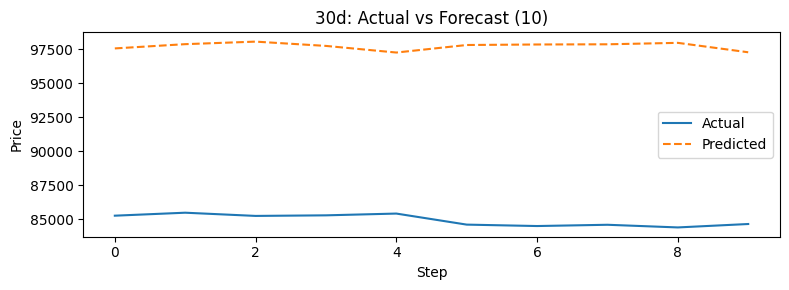

Horizons: 100%|██████████| 10/10 [27:42<00:00, 166.22s/it]

30d: RMSE=12793.07, MAPE=15.05%



In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths
TRAIN_PATH = '/kaggle/input/data-btc/fix2/fix2/train.csv'
VAL_PATH   = '/kaggle/input/data-btc/fix2/fix2/val.csv'
TEST_PATH  = '/kaggle/input/data-btc/fix2/fix2/test.csv'

# 1) Load splits
df_tr = pd.read_csv(TRAIN_PATH, parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_va = pd.read_csv(VAL_PATH,   parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])
df_te = pd.read_csv(TEST_PATH,  parse_dates=['timestamp']).drop(columns=['timestamp','close_time'])

# 2) Combine train+val for initial STL history
df_hist_init = pd.concat([df_tr, df_va], ignore_index=True)

# 3) Horizons and period
horizons = {'1h':1,'2h':2,'3h':3,'6h':6,'12h':12,'1d':24,'3d':72,'7d':168,'15d':360,'30d':720}
PERIOD = 24
FEATURES = ['close','trend','season']

for label, h in tqdm(horizons.items(), desc='Horizons'):
    # --- Prepare train+val history and test splits ---
    def prepare(df_full, h):
        df = df_full.copy()
        df['label'] = df['close'].shift(-h)
        df.dropna(subset=['label'], inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    df_hist = prepare(pd.concat([df_tr, df_va], ignore_index=True), h)
    df_test = prepare(df_te, h)

    # === VERIFY df_test indexing ===
    # Pastikan 10 baris pertama df_test adalah yang diinginkan
    print(f"\n--- {label} TEST VERIFICATION (first 10 rows) ---")
    print(df_test[['close','label']].head(10))

    # --- Initial STL on history (train+val) ---
    stl_init = STL(df_hist['close'], period=PERIOD, robust=True).fit()
    df_hist['trend']   = stl_init.trend
    df_hist['season']  = stl_init.seasonal
    df_hist['residual']= df_hist['label'] - (df_hist['trend'] + df_hist['season'])

    X_hist0 = df_hist[FEATURES]
    y_hist0 = df_hist['residual'].values

    # --- Tune LGBM ---
    tqdm.write(f'[LGBM Tune] {label}')
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators',100,500),
            'num_leaves':    trial.suggest_int('num_leaves',16,64),
            'max_depth':     trial.suggest_int('max_depth',3,10),
            'learning_rate': trial.suggest_float('learning_rate',1e-3,1e-1,log=True),
            'feature_fraction': trial.suggest_float('feature_fraction',0.6,1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction',0.6,1.0),
            'min_child_samples': trial.suggest_int('min_child_samples',5,30),
            'verbose': -1, 'device':'gpu'
        }
        tss = TimeSeriesSplit(n_splits=3); ms=[]
        for ti,vi in tss.split(X_hist0):
            m = LGBMRegressor(random_state=42, **params)
            m.fit(X_hist0.iloc[ti], y_hist0[ti])
            ms.append(mean_squared_error(y_hist0[vi], m.predict(X_hist0.iloc[vi])))
        return np.mean(ms)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    best_lgbm = study.best_trial.params
    tqdm.write(f'  best_lgbm = {best_lgbm}')

    # --- Walk-forward validation with online STL, 10 points ---
    tqdm.write(f'[WFV] {label} (10 pts)')
    preds, trues = [], []

    # Initialize history arrays
    history_close = df_hist['close'].to_numpy()
    history_label = df_hist['label'].to_numpy()

    max_pts = min(10, len(df_test))
    for i in tqdm(range(max_pts), desc=f'WFV {label}'):
        # a) Append test close for STL
        test_close = df_test['close'].iloc[i]
        hist_close_full = np.append(history_close, test_close)

        # b) Online STL on hist_close_full
        stl = STL(hist_close_full, period=PERIOD, robust=True).fit()
        trend_full  = stl.trend
        season_full = stl.seasonal

        # c) Build retrain DataFrame up to before test_i
        n_hist = len(history_close)
        df_retrain = pd.DataFrame({
            'close':  hist_close_full[:n_hist],
            'trend':  trend_full[:n_hist],
            'season': season_full[:n_hist],
            'label':  history_label
        })
        df_retrain['residual'] = df_retrain['label'] - (df_retrain['trend'] + df_retrain['season'])
        Xr = df_retrain[FEATURES]; yr = df_retrain['residual'].values

        # d) Retrain LGBM
        lgbm = LGBMRegressor(random_state=42, **best_lgbm)
        lgbm.fit(Xr, yr)

        # e) Predict residual for test_i
        feat = pd.DataFrame({
            'close':  [test_close],
            'trend':  [trend_full[n_hist]],
            'season': [season_full[n_hist]]
        })
        resid_pred = lgbm.predict(feat)[0]
        forecast = feat['trend'][0] + feat['season'][0] + resid_pred

        preds.append(forecast)
        trues.append(df_test['label'].iloc[i])

        # f) Update history with ground truth
        history_close = np.append(history_close, test_close)
        history_label = np.append(history_label, df_test['label'].iloc[i])

    # --- Plot & metrics ---
    plt.figure(figsize=(8,3))
    plt.plot(trues, label='Actual')
    plt.plot(preds, '--', label='Predicted')
    plt.title(f'{label}: Actual vs Forecast (10)')
    plt.xlabel('Step'); plt.ylabel('Price')
    plt.legend(); plt.tight_layout(); plt.show()

    rmse = mean_squared_error(trues, preds, squared=False)
    mape = mean_absolute_percentage_error(trues, preds)*100
    tqdm.write(f'{label}: RMSE={rmse:.2f}, MAPE={mape:.2f}%\n')
